Epoch 0, Train Loss: 0.6897, Val Loss: 0.6898, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 10, Train Loss: 0.4998, Val Loss: 0.5409, Train Acc: 0.6515, Val Acc: 0.6494
Epoch 20, Train Loss: 0.4845, Val Loss: 0.5357, Train Acc: 0.7980, Val Acc: 0.7403
Epoch 30, Train Loss: 0.4748, Val Loss: 0.5305, Train Acc: 0.8013, Val Acc: 0.7208
Epoch 40, Train Loss: 0.4667, Val Loss: 0.5279, Train Acc: 0.8029, Val Acc: 0.7273
Epoch 50, Train Loss: 0.4587, Val Loss: 0.5223, Train Acc: 0.8013, Val Acc: 0.7273
Epoch 60, Train Loss: 0.4511, Val Loss: 0.5214, Train Acc: 0.8046, Val Acc: 0.7403
Epoch 70, Train Loss: 0.4442, Val Loss: 0.5185, Train Acc: 0.8046, Val Acc: 0.7338
Epoch 80, Train Loss: 0.4381, Val Loss: 0.5195, Train Acc: 0.8013, Val Acc: 0.7273
Epoch 90, Train Loss: 0.4323, Val Loss: 0.5103, Train Acc: 0.7964, Val Acc: 0.7273

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       100
           1       0.64      0.59     

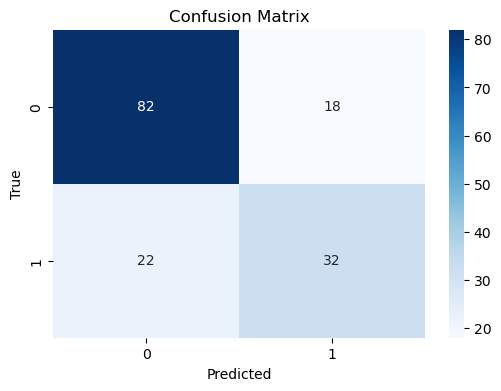

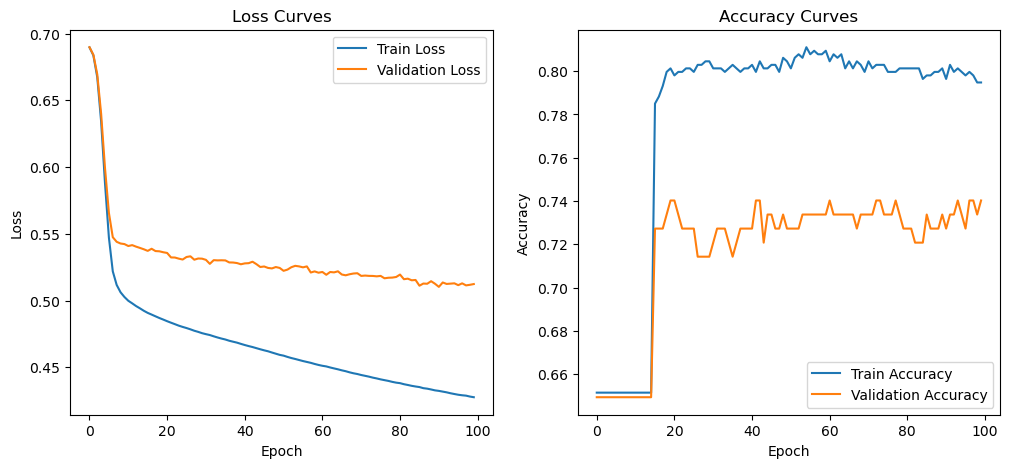

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Activation functions
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    # Clip x to avoid overflow in exp
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

# Neural Network class with Adam optimizer
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes must be a list with at least 2 elements"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate, (int, float)) and learning_rate > 0, "Learning rate must be a positive number"
        assert 0 <= beta1 < 1 and 0 <= beta2 < 1, "Beta parameters must be in [0,1)"
        assert isinstance(epsilon, (int, float)) and epsilon > 0, "Epsilon must be a positive number"
        
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weights = []
        self.biases = []
        
        # Initialize weights and biases
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]), f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector {i+1} has incorrect shape"
        
        # Initialize Adam moment estimates
        self.m_weights = [np.zeros_like(w) for w in self.weights]
        self.v_weights = [np.zeros_like(w) for w in self.weights]
        self.m_biases = [np.zeros_like(b) for b in self.biases]
        self.v_biases = [np.zeros_like(b) for b in self.biases]
        self.t = 0  # Time step for bias correction

    def forward(self, X):
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        
        self.activations = [X]
        self.z_values = []
        
        # Forward propagation through hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]), f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(z)
            a = relu(z)
            self.activations.append(a)
        
        # Output layer
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        assert z.shape == (X.shape[0], self.layer_sizes[-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        output = sigmoid(z)
        assert output.shape == (X.shape[0], self.layer_sizes[-1]), "Output A has incorrect shape"
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to loss must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        assert np.all((y_true == 0) | (y_true == 1)), "y_true must contain only 0s and 1s"
        
        m = y_true.shape[0]
        # Binary cross-entropy loss
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Avoid log(0)
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
        return loss

    def compute_accuracy(self, y_true, y_pred):
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Inputs to accuracy must be numpy arrays"
        assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
        
        predictions = (y_pred >= 0.5).astype(int)
        accuracy = np.mean(predictions == y_true)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self, X, y, outputs, l2_lambda=0.01):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Inputs to backward must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape == outputs.shape, "y and outputs must have the same shape"
        
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        
        # Output layer gradient
        dZ = outputs - y
        assert dZ.shape == outputs.shape, "dZ for output layer has incorrect shape"
        self.d_weights[-1] = (np.dot(self.activations[-2].T, dZ) / m) + (l2_lambda * self.weights[-1] / m)  # L2 regularization
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        
        # Hidden layers gradients
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i+1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = (np.dot(self.activations[i].T, dZ) / m) + (l2_lambda * self.weights[i] / m)  # L2 regularization
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        
        # Adam update
        self.t += 1  # Increment time step
        for i in range(len(self.weights)):
            # Update first moment (mean)
            self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
            self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
            # Update second moment (uncentered variance)
            self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
            self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
            # Bias correction
            m_hat_w = self.m_weights[i] / (1 - self.beta1 ** self.t)
            m_hat_b = self.m_biases[i] / (1 - self.beta1 ** self.t)
            v_hat_w = self.v_weights[i] / (1 - self.beta2 ** self.t)
            v_hat_b = self.v_biases[i] / (1 - self.beta2 ** self.t)
            # Update parameters
            self.weights[i] -= self.learning_rate * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
            self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val, np.ndarray) and isinstance(y_val, np.ndarray), "X_val and y_val must be numpy arrays"
        assert X.shape[1] == self.layer_sizes[0], f"Input dimension ({X.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y.shape[1] == self.layer_sizes[-1], f"Output dimension ({y.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert X_val.shape[1] == self.layer_sizes[0], f"Validation input dimension ({X_val.shape[1]}) must match input layer size ({self.layer_sizes[0]})"
        assert y_val.shape[1] == self.layer_sizes[-1], f"Validation output dimension ({y_val.shape[1]}) must match output layer size ({self.layer_sizes[-1]})"
        assert isinstance(epochs, int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size, int) and batch_size > 0, "Batch size must be a positive integer"
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                batch_indices = indices[i:min(i + batch_size, X.shape[0])]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            
            # Compute metrics for training and validation
            train_outputs = self.forward(X)
            val_outputs = self.forward(X_val)
            train_loss = self.compute_loss(y, train_outputs)
            val_loss = self.compute_loss(y_val, val_outputs)
            train_accuracy = self.compute_accuracy(y, train_outputs)
            val_accuracy = self.compute_accuracy(y_val, val_outputs)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        outputs = self.forward(X)
        return (outputs >= 0.5).astype(int)

# Data preprocessing
def preprocess_data():
    # Load dataset
    data = pd.read_csv('diabetes.csv')
    
    # Replace invalid zeros with median
    columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    for col in columns_with_zeros:
        data[col] = data[col].replace(0, data[col][data[col] != 0].median())
    
    # Features and target
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values.reshape(-1, 1)
    
    # Standardize features
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Main execution
if __name__ == "__main__":
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data()
    
    # Initialize and train neural network with Adam
    layer_sizes = [X_train.shape[1], 16, 8, 1]
    nn = NeuralNetwork(layer_sizes, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_test, y_test, epochs=100, batch_size=32)
    
    # Evaluate on test set
    y_pred = nn.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix_adam.png')
    plt.show()
    # Plot loss and accuracy curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss curves
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Accuracy curves
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.savefig('loss_accuracy_curves_adam.png')
    plt.show()